### Import the required libraries

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np 
import PIL 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Download the dataset

In [2]:
# Classes we have in our data set.
total_classes = os.listdir("/kaggle/input/alzheimer-mri-dataset/Dataset")
total_classes

['Non_Demented', 'Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented']

In [3]:
# Total number of images per class.
images_path = Path("/kaggle/input/alzheimer-mri-dataset/Dataset")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* Non_Demented = 3200 images
* Mild_Demented = 896 images
* Moderate_Demented = 64 images
* Very_Mild_Demented = 2240 images


We can see a class imbalance here !

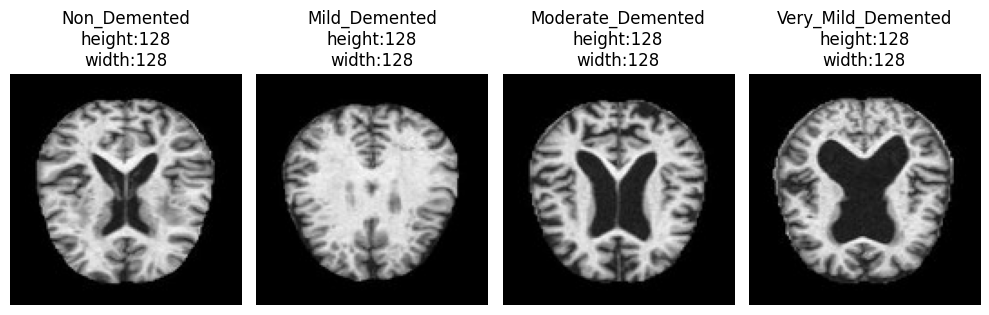

In [4]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


### Visualize the data

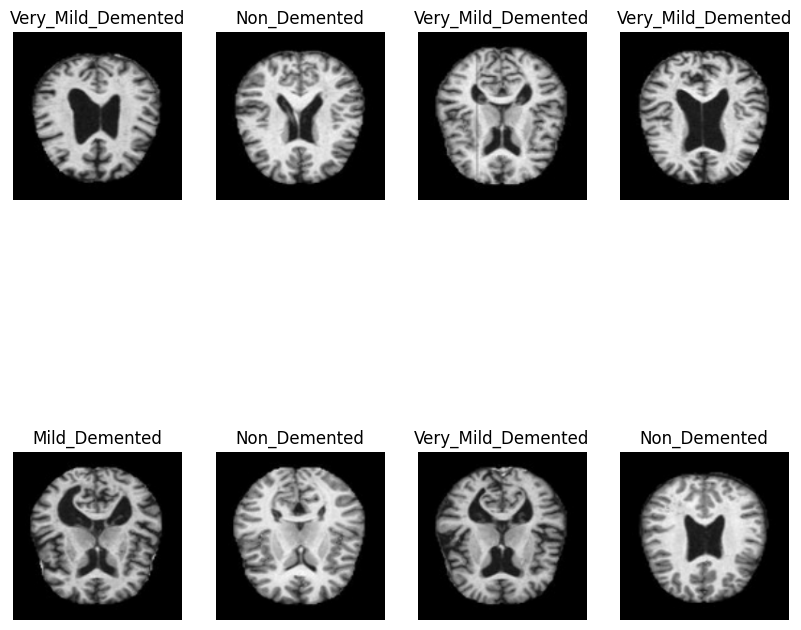

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Configure the data for higher performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardizing the dataset

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 0.98570955


### Create the Model

In [14]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

### Compile the Model

In [15]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the Model

In [17]:
epochs = 10 

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
160/160 [==============================] - 12s 23ms/step - loss: 0.9841 - accuracy: 0.5342 - val_loss: 0.8367 - val_accuracy: 0.6125
Epoch 2/10
160/160 [==============================] - 2s 15ms/step - loss: 0.7706 - accuracy: 0.6553 - val_loss: 0.6024 - val_accuracy: 0.7312
Epoch 3/10
160/160 [==============================] - 2s 15ms/step - loss: 0.4660 - accuracy: 0.8117 - val_loss: 0.3990 - val_accuracy: 0.8328
Epoch 4/10
160/160 [==============================] - 2s 15ms/step - loss: 0.2240 - accuracy: 0.9145 - val_loss: 0.2275 - val_accuracy: 0.9102
Epoch 5/10
160/160 [==============================] - 2s 15ms/step - loss: 0.0996 - accuracy: 0.9623 - val_loss: 0.1502 - val_accuracy: 0.9508
Epoch 6/10
160/160 [==============================] - 2s 15ms/step - loss: 0.0783 - accuracy: 0.9711 - val_loss: 0.6036 - val_accuracy: 0.8070
Epoch 7/10
160/160 [==============================] - 2s 15ms/step - loss: 0.1440 - accuracy: 0.9484 - val_loss: 0.1053 - val_accuracy: 0.965

### Visualizing the results

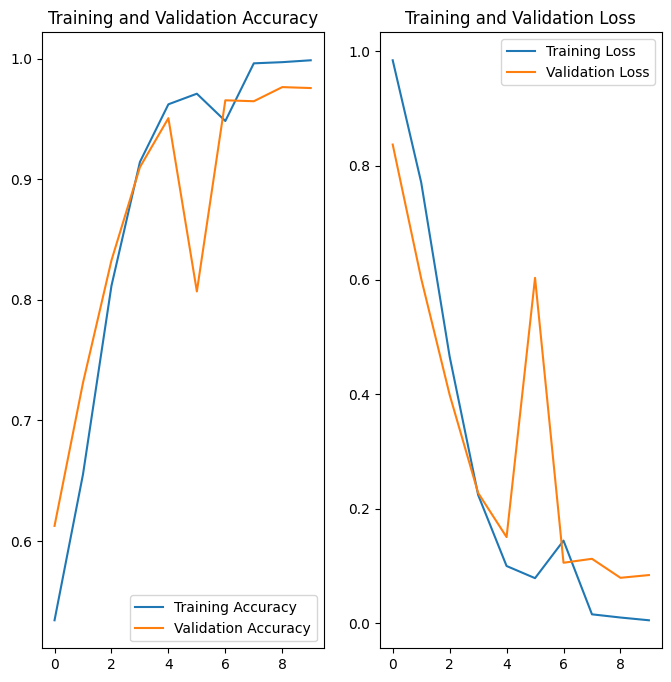

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data Augmentation

In [19]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),
    
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

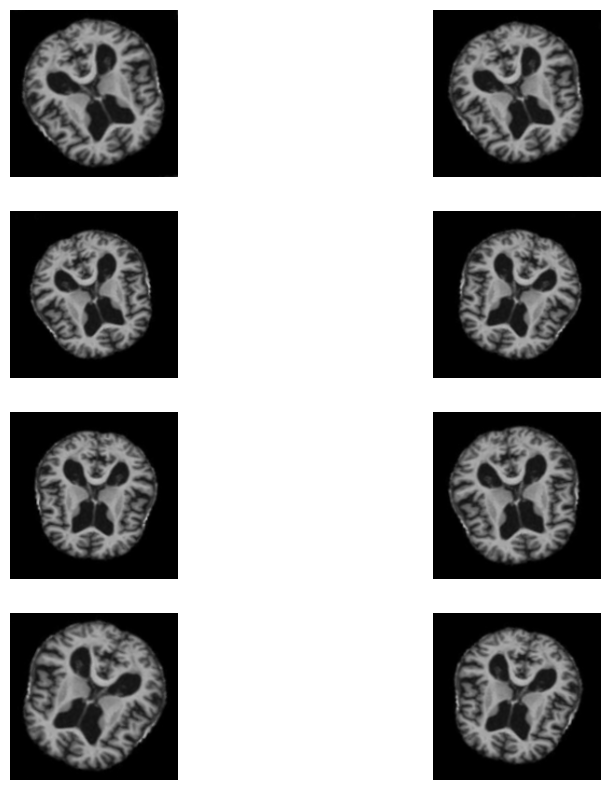

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Adding Dropout Layer

In [21]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [24]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50


2023-11-11 14:33:40.691891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


160/160 [==============================] - 5s 20ms/step - loss: 0.9775 - accuracy: 0.5350 - val_loss: 0.8894 - val_accuracy: 0.5781
Epoch 2/50
160/160 [==============================] - 3s 19ms/step - loss: 0.7433 - accuracy: 0.6658 - val_loss: 0.6106 - val_accuracy: 0.7547
Epoch 3/50
160/160 [==============================] - 3s 19ms/step - loss: 0.4490 - accuracy: 0.8180 - val_loss: 0.6145 - val_accuracy: 0.7148
Epoch 4/50
160/160 [==============================] - 3s 19ms/step - loss: 0.2287 - accuracy: 0.9104 - val_loss: 0.2342 - val_accuracy: 0.9164
Epoch 5/50
160/160 [==============================] - 3s 19ms/step - loss: 0.1271 - accuracy: 0.9508 - val_loss: 0.2305 - val_accuracy: 0.9039
Epoch 6/50
160/160 [==============================] - 3s 19ms/step - loss: 0.0989 - accuracy: 0.9643 - val_loss: 0.1519 - val_accuracy: 0.9461
Epoch 7/50
160/160 [==============================] - 3s 19ms/step - loss: 0.0452 - accuracy: 0.9844 - val_loss: 0.0837 - val_accuracy: 0.9680
Epoch 8/50

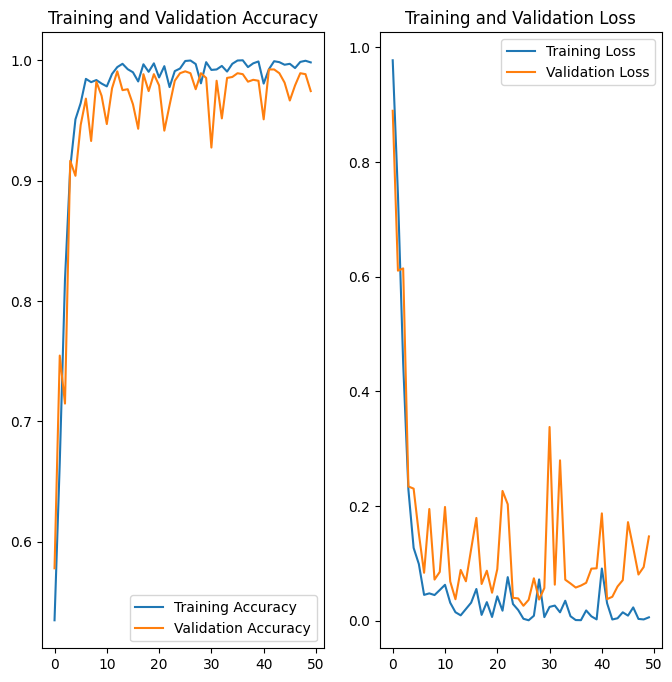

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Save the Model

In [26]:
# Save the Keras model as an HDF5 file
model.save("alzeihmer_model.h5")